In [1]:
%matplotlib inline
import math
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import datetime
from collections import defaultdict

df = pd.read_csv('D://Documenti//Università//Informatica Umanistica//DMII//occupancy_data//datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

In [2]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

###### Preparazione training

In [3]:
dates = pd.to_datetime(df['date'], infer_datetime_format=True)
df['day'] = dates.dt.day
df['absH'] = dates.dt.hour

In [4]:
del df['HumidityRatio']
del df['date']

In [5]:
class_name = 'Occupancy'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,day,absH,Occupancy
1,23.18,27.2720,426.0,721.25,4,17,1
2,23.15,27.2675,429.5,714.00,4,17,1
3,23.15,27.2450,426.0,713.50,4,17,1
4,23.15,27.2000,426.0,708.25,4,17,1
5,23.10,27.2000,426.0,704.50,4,17,1


###### Preparazione validation

In [6]:
dfVal = pd.read_csv('D://Documenti//Università//Informatica Umanistica//DMII//occupancy_data//datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

In [7]:
dates = pd.to_datetime(dfVal['date'], infer_datetime_format=True)
dfVal['day'] = dates.dt.day
dfVal['absH'] = dates.dt.hour

In [8]:
del dfVal['HumidityRatio']
del dfVal['date']

In [9]:
dfVal.head()

,Temperature,Humidity,Light,CO2,Occupancy,day,absH
1,21.7600,31.133333,437.333333,1029.666667,1,11,14
2,21.7900,31.000000,437.333333,1000.000000,1,11,14
3,21.7675,31.122500,434.000000,1003.750000,1,11,14
4,21.7675,31.122500,439.000000,1009.500000,1,11,14
5,21.7900,31.133333,437.333333,1005.666667,1,11,14


Unisco i due dataset

In [10]:
df_conc=pd.concat([df,dfVal])

# Splitting

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
attributes = [col for col in df_conc.columns if col != class_name]
X = df_conc[attributes].values
y = df_conc[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [15]:
#import pickle
#pickle.dump(clf, 'filename.pickle')
#clf = pickle.load('filename.pickle')

Primo run con valori standard: gini index, no pruning, max_features =  sqrt(n)

In [16]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.995343639411436
F1-score [0.99704596 0.98901099]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       0.99      0.99      0.99      1134

    accuracy                           1.00      5369
   macro avg       0.99      0.99      0.99      5369
weighted avg       1.00      1.00      1.00      5369



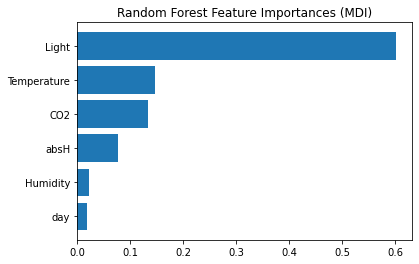

In [17]:
nbr_features = 7

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(feature_names)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [18]:
import pydotplus
from sklearn import tree
from IPython.display import Image

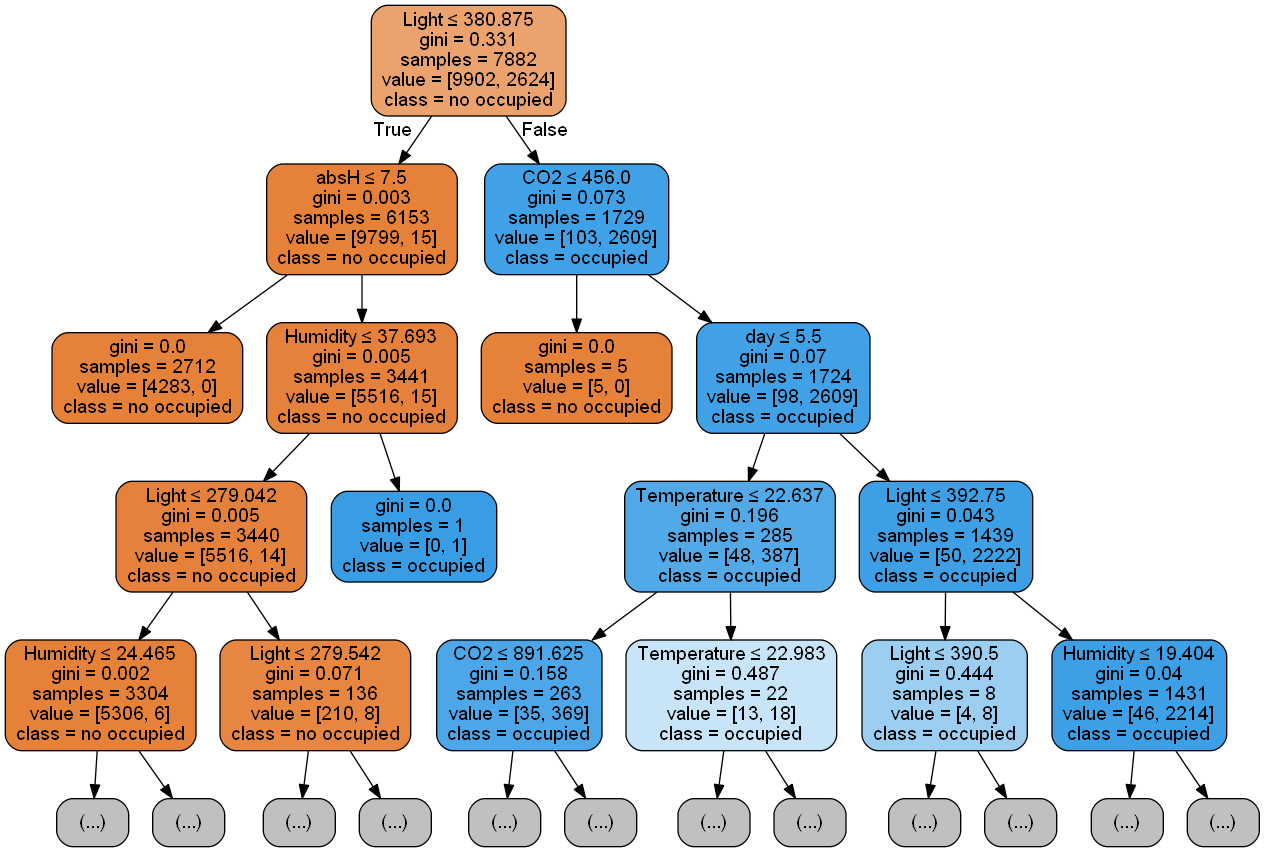

In [19]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['no occupied', 'occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

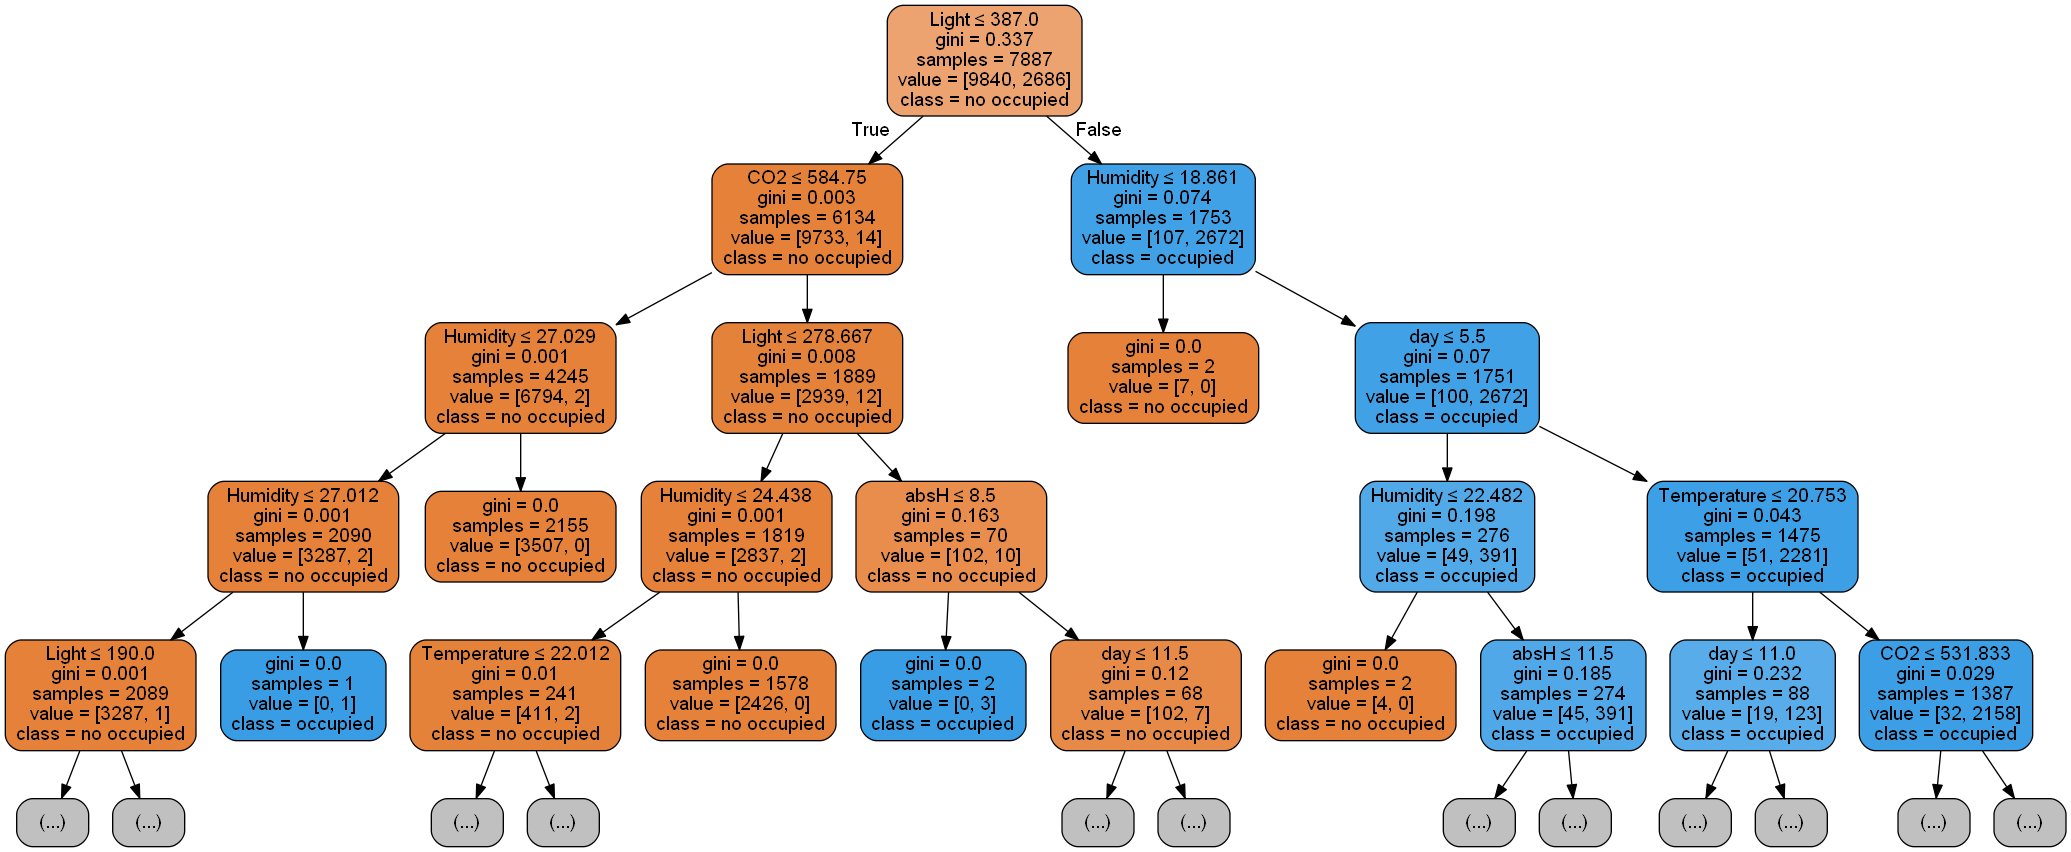

In [20]:
dot_data = tree.export_graphviz(clf.estimators_[99], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['no occupied', 'occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

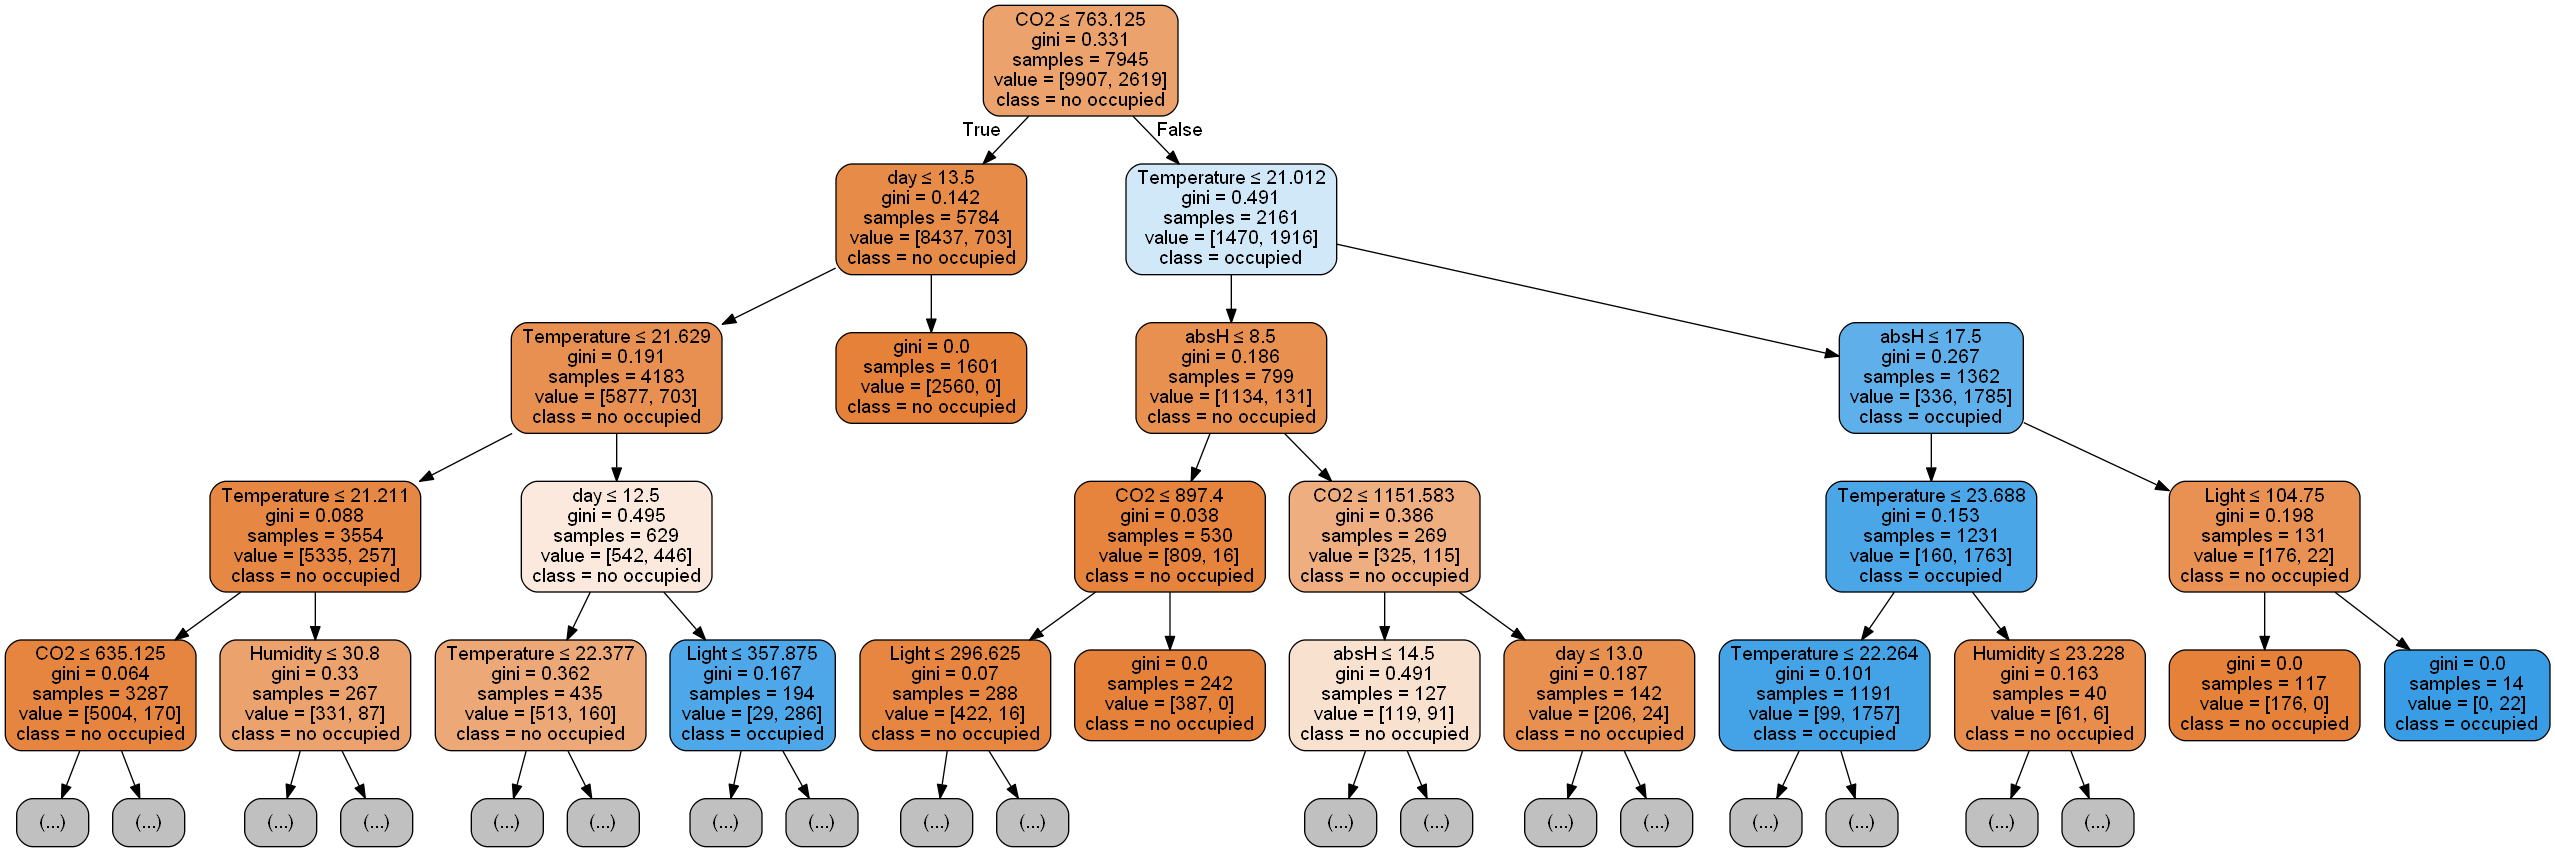

In [21]:
dot_data = tree.export_graphviz(clf.estimators_[17], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['no occupied', 'occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Secondo run con max_features = log(n)

In [22]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))



Accuracy 0.995343639411436
F1-score [0.99704596 0.98901099]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       0.99      0.99      0.99      1134

    accuracy                           1.00      5369
   macro avg       0.99      0.99      0.99      5369
weighted avg       1.00      1.00      1.00      5369



Terzo run con entropia

In [23]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9945986217172658
F1-score [0.99657332 0.98725275]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       0.98      0.99      0.99      1134

    accuracy                           0.99      5369
   macro avg       0.99      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



Valori leggermente inferiori ma comunque molto alti

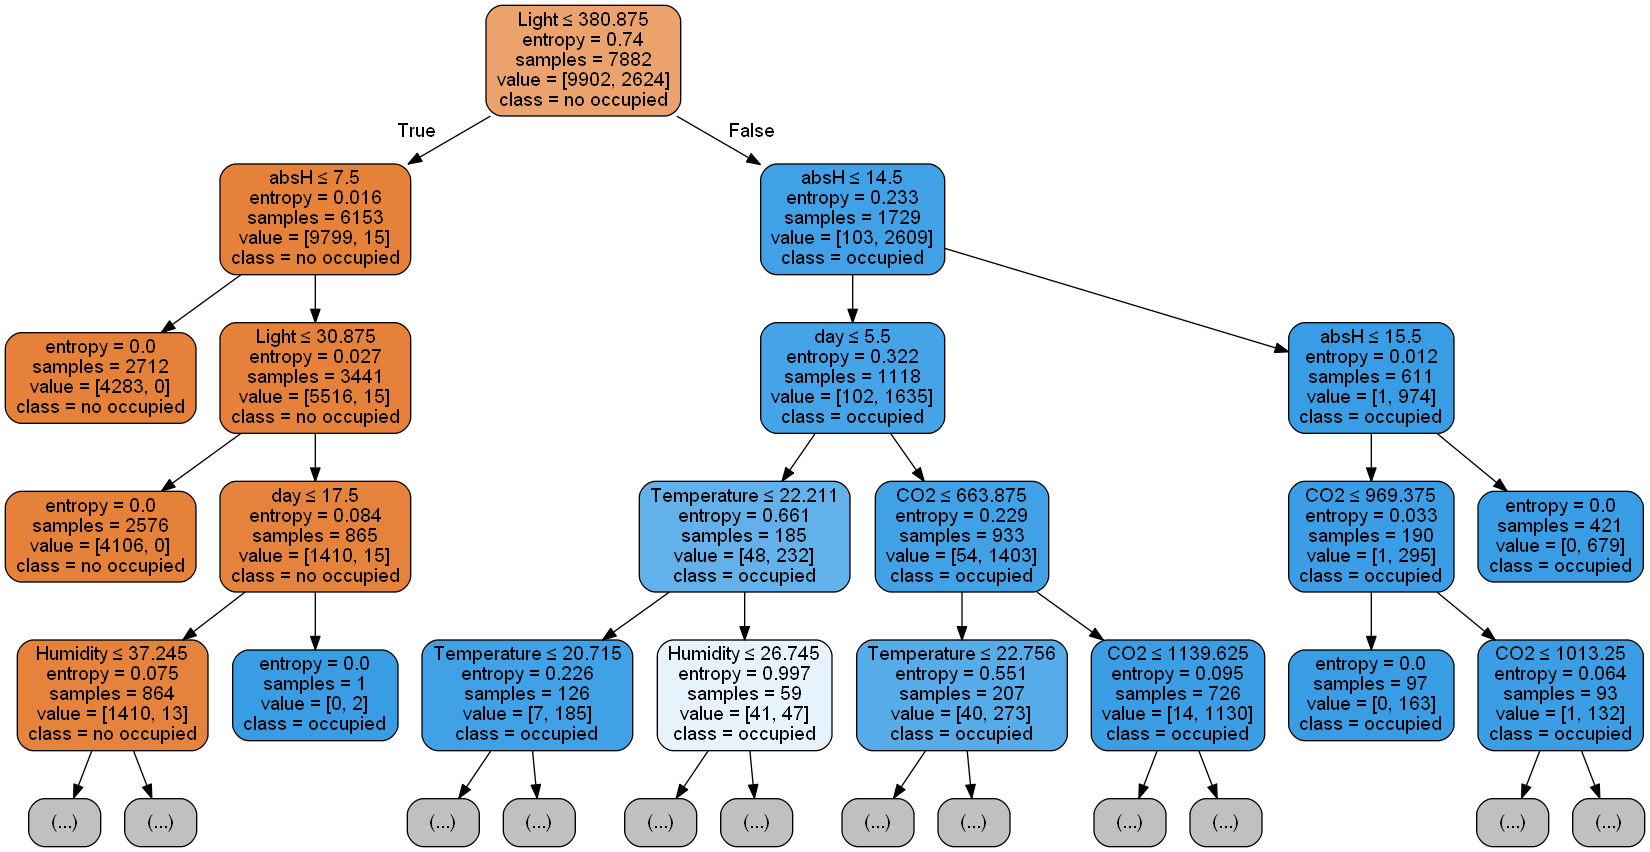

In [24]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['no occupied', 'occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Quarto run con entropy e pruning

In [25]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=500, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9916185509405848
F1-score [0.99467519 0.98032357]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4235
           1       0.97      0.99      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



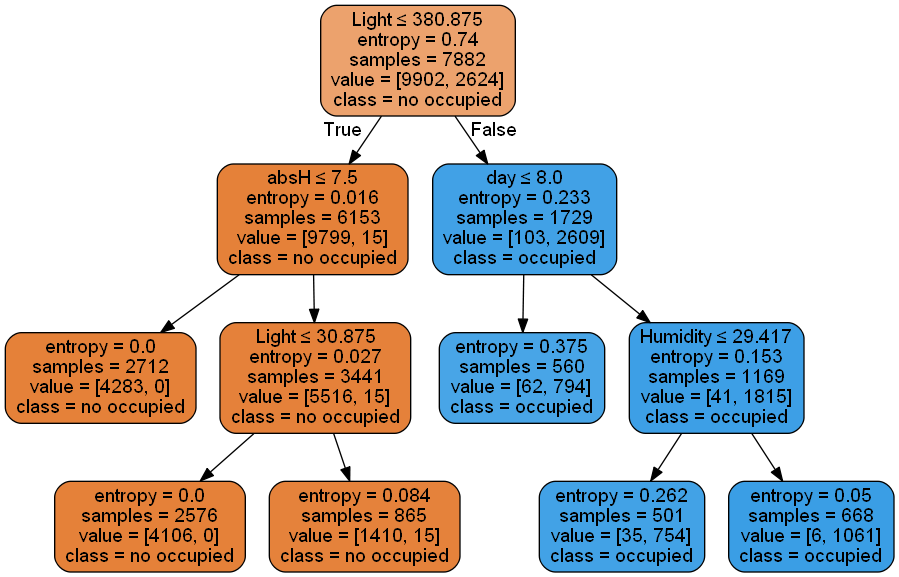

In [26]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['no occupied', 'occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

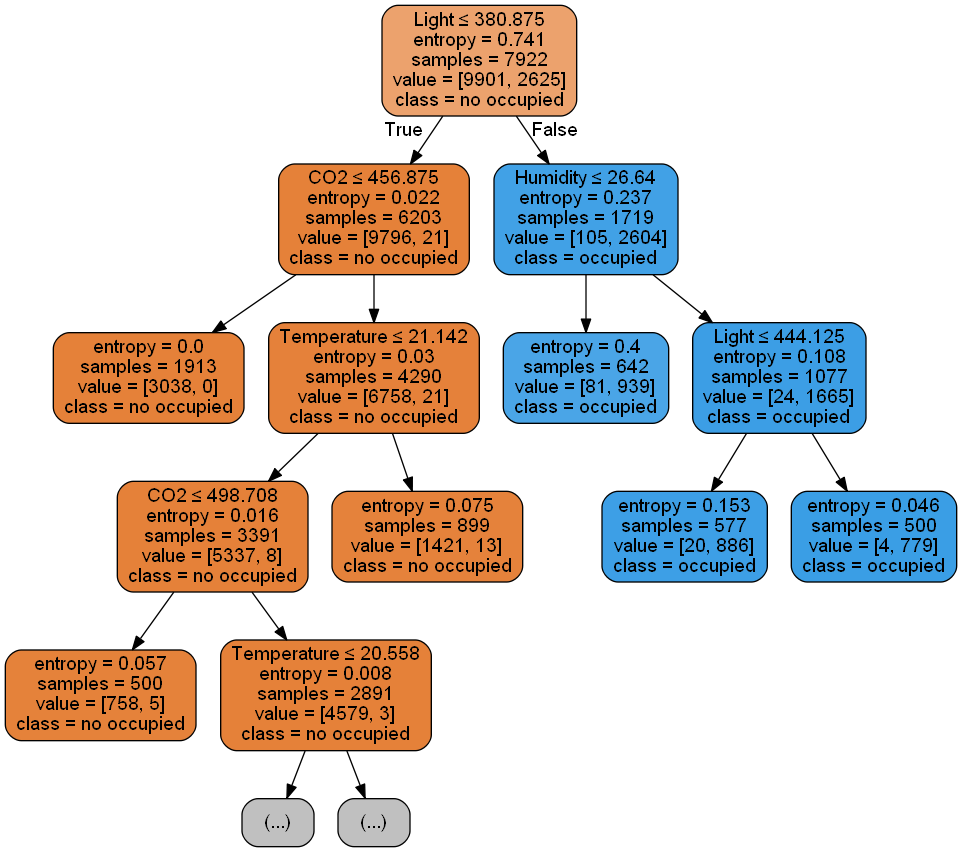

In [27]:
dot_data = tree.export_graphviz(clf.estimators_[48], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['no occupied', 'occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Cross Validation

In [28]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import ShuffleSplit

clf = RandomForestClassifier()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(clf, X, y, cv=cv)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.994 +/- 0.001


### GridSearch

In [29]:
from sklearn.model_selection import RandomizedSearchCV
param_list = {'n_estimators': [100],
              'min_samples_leaf' : [1, 500],
              'criterion' : ['entropy', 'gini']
             }
clf =  RandomForestClassifier()

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy 0.9949711305643509
F1-score [0.9968104  0.98812143]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       0.99      0.99      0.99      1134

    accuracy                           0.99      5369
   macro avg       0.99      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



In [30]:
random_search.cv_results_['params'][random_search.cv_results_['rank_test_score'][0]]

{'n_estimators': 100, 'min_samples_leaf': 500, 'criterion': 'entropy'}

## Bagging

In [29]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [30]:
clf = BaggingClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9944123672937232
F1-score [0.99645558 0.98680739]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       0.98      0.99      0.99      1134

    accuracy                           0.99      5369
   macro avg       0.99      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



In [31]:
clf = BaggingClassifier(base_estimator=SVC(C=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9925498230582976
F1-score [0.99525954 0.9826087 ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



In [32]:
clf = BaggingClassifier(base_estimator=SVC(C=1000), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9925498230582976
F1-score [0.99525954 0.9826087 ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



In [33]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9949711305643509
F1-score [0.99680889 0.98814229]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       0.98      0.99      0.99      1134

    accuracy                           0.99      5369
   macro avg       0.99      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=90), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9929223319053827
F1-score [0.99549763 0.98346388]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



### Cross Validation

In [43]:
from sklearn.model_selection import cross_val_score 


clf = BaggingClassifier()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(clf, X, y, cv=cv)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.993 +/- 0.001


In [36]:
from sklearn.ensemble import AdaBoostClassifier

In [37]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9940398584466381
F1-score [0.99621212 0.9860262 ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.98      1.00      0.99      1134

    accuracy                           0.99      5369
   macro avg       0.99      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



In [38]:
clf = AdaBoostClassifier(base_estimator= RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9944123672937232
F1-score [0.99645558 0.98680739]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       0.98      0.99      0.99      1134

    accuracy                           0.99      5369
   macro avg       0.99      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



### Cross Validation

In [42]:
from sklearn.model_selection import cross_val_score 


clf = AdaBoostClassifier()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(clf, X, y, cv=cv)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.990 +/- 0.001
